In [46]:
from math import sqrt, pi, exp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
data = pd.read_csv('data1.csv', delimiter=',')
N = len(data)

data['GPS Speed (Meters/second)'] = ['0' if elem == '-' else elem 
                                     for i, elem in enumerate(data['GPS Speed (Meters/second)'])]

In [47]:
#Данные скорости с GPS и OBD
z_GPS = np.array(data['GPS Speed (Meters/second)'])
z_OBD = np.array(data['Speed (OBD)(km/h)']) / 3.6

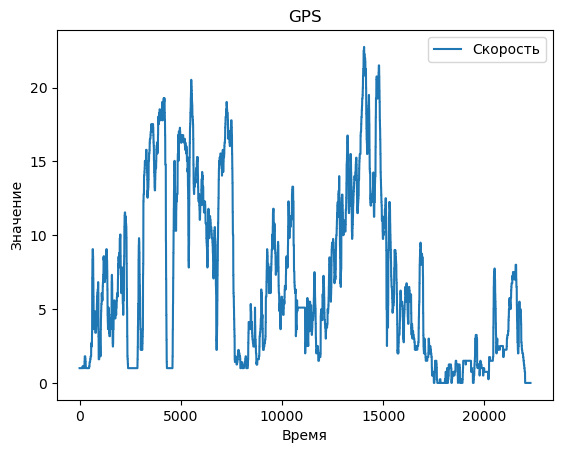

In [48]:
plt.plot(range(1, N + 1), z_GPS, label="Скорость")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("GPS")
plt.legend()
plt.show()

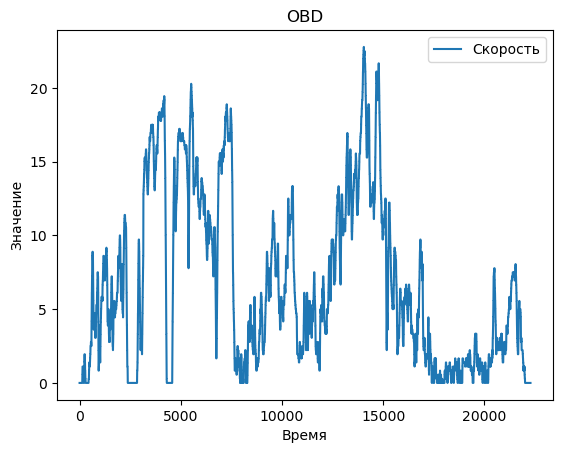

In [49]:
plt.plot(range(1, N + 1), z_OBD, label="Скорость")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title("OBD")
plt.legend()
plt.show()

In [50]:
def plot_graf(v, z_GPS, z_OBD):
    #Строим графики
    plt.plot(range(1, 500 + 1), v[:500], label="Фильтрованная оценка")
    plt.plot(range(1, 500 + 1), z_GPS[:500], label="Измерение GPS")
    plt.plot(range(1, 500 + 1), z_OBD[:500], label="Измерение ODB")
    plt.xlabel("Время")
    plt.ylabel("Значение")
    plt.title("Фильтр Калмана для первых 500 значений")
    plt.legend()
    plt.show()
    #Строим графики
    plt.plot(range(1, N + 1), v, label="Фильтрованная оценка")
    plt.plot(range(1, N + 1), z_GPS, label="Измерение GPS")
    plt.plot(range(1, N + 1), z_OBD, label="Измерение ODB")
    plt.xlabel("Время")
    plt.ylabel("Значение")
    plt.title("Фильтр Калмана")
    plt.legend()
    plt.show()

In [51]:
class KalmanFilter:
    def __init__(self, F, B, Q, H, R, P, x):
        """
        Инициализация фильтра Калмана
        F (np.ndarray): Матрица перехода состояний.
        B (np.ndarray): Матрица управляющего воздействия.
        Q (np.ndarray): Ковариация шума процесса.
        H (np.ndarray): Матрица измерений
        R (np.ndarray): Ковариационная матрица измерений шума.
        P (np.ndarray): Ковариационная матрица ошибки оценки.
        x (np.ndarray): Вектор начальной оценки состояния.
        """
        self.F = F
        self.B = B
        self.Q = Q
        self.H = H
        self.R = R
        self.P = P
        self.x = x

    def predict(self, u=np.zeros((2,2))):
        
        #self.x = self.F*self.x + self.B*u
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)

        #self.P = self.F*self.P*(self.F.T) + self.Q
        self.P = np.dot(np.dot(self.F, self.P), (self.F.T)) + self.Q

        return self.x, self.P
    

    def update(self, H, R, z):

        self.H = H

        self.R = R

        #y = z - self.H*self.x
        y = z - np.dot(self.H, self.x)
        
        #K = self.P*(self.H.T)*np.linalg.inv(self.H*self.P*(self.H.T)+self.R)
        K = np.dot(np.dot(self.P, (self.H.T)), np.linalg.inv(np.dot(np.dot(self.H, self.P), (self.H.T))+self.R))
        
        #self.x = self.x + K*y
        self.x = self.x + np.dot(K, y)

        #self.P =  self.P - K*self.H*self.P
        self.P =  self.P - np.dot(np.dot(K, self.H), self.P)

        return self.x, self.P
    
        

In [52]:
F = np.array([[1.0, 0.1, 0.0, 0.0], 
              [0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.1],
              [0.0, 0.0, 0.0, 1.0]])

B = 0

Q = np.array([[0.0, 0.0, 0.0, 0.0], 
              [0.0, 6.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 6.0]])

H1 = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 0.0],
               [0.0, 0.0, 0.0, 1.0],
               [0.0, 1.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 1.0]])#????

H2 = np.array([[0.0, 1.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 1.0]])

R1 = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 4.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 4.0]])

R2 = np.array([[4.0, 0.0], 
              [0.0, 4.0]])

P = np.array([[1.0, 0.0, 0.0, 0.0], 
              [0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])

x = np.array([[0.0],
              [0.0],
              [0.0],
              [0.0]])
print(np.shape(x))
v = [0]*N
v1 = [0]*N

#Берем скорость из данных в датафрейме

#z_GPS = data['GPS Speed (Meters/second)'].astype (float)
v_obd = (data['Speed (OBD)(km/h)'].astype (float))/3.6
v_gps = np.array(data['GPS Speed (Meters/second)'].astype (float))
sigmaGPS_arr = data[' Horizontal Dilution of Precision'].astype (float)
bearing = np.array(data[' Bearing'].astype (float))

#получаем координаты и скорость по x
Longitude = (data[' Longitude'].astype (float))
Latitude = (data[' Latitude'].astype (float))

avr_gr = np.cos((sum(Latitude)/len(Latitude))*np.pi/180)*111.111# по x
Longitude = [avr_gr*Longitude[i]*1000 for i in range(N)]
Longitude = [Longitude[i] - Longitude[0] for i in range(N)]
Lon_x = Longitude

#Берем какую-то из составляющих скорости...
v_gps_x = np.sin(bearing*np.pi/180)*v_gps
v_obd_x = np.sin(bearing*np.pi/180)*v_obd

#получаем координаты и скорость по y
Latitude = (data[' Latitude'].astype (float))*111.111*1000 # по y
Latitude = [Latitude[i] - Latitude[0] for i in range(N)]
Lat_y = Latitude

#Берем какую-то из составляющих скорости...
v_gps_y = np.cos(bearing*np.pi/180)*v_gps
v_obd_y = np.cos(bearing*np.pi/180)*v_obd



kf = KalmanFilter(F, B, Q, H1, R1, P, x)

for t in range(0, N-1):
    v[t+1], P_buf = kf.predict(0)
    if (t%10 == 0):
        R1 = np.array([[sigmaGPS_arr[t], 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, sigmaGPS_arr[t], 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, sigmaGPS_arr[t], 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, sigmaGPS_arr[t], 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 4.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 4.0]])
        
        v[t+1], P_buf = kf.update(H1, R1,
                                np.array([[Lon_x[t]],
                                        [v_gps_x[t]],
                                        [Lat_y[t]], 
                                        [v_gps_y[t]],
                                        [v_obd_x[t]],
                                        [v_obd_y[t]]]))
    else:
        v[t+1], P_buf = kf.update(H2, R2,  
                                  np.array([[v_obd_x[t]],
                                        [v_obd_y[t]]]))
        


buf_x = [0]*len(v)
buf_y = [0]*len(v)
buf_Vx = [0]*len(v)
buf_Vy = [0]*len(v)
for i in range(2, len(v)):
    buf_x[i] = v[i][0][0]
    buf_Vx[i] = v[i][1][0]
    buf_y[i] = v[i][2][0]
    buf_Vy[i] = v[i][3][0]
print(v)



(4, 1)
[0, array([[0.        ],
       [0.        ],
       [0.00205005],
       [0.15384165]]), array([[0.        ],
       [0.        ],
       [0.01434468],
       [0.05063169]]), array([[0.        ],
       [0.        ],
       [0.01801593],
       [0.01596769]]), array([[0.        ],
       [0.        ],
       [0.01913159],
       [0.00501398]]), array([[0.        ],
       [0.        ],
       [0.01947761],
       [0.00157376]]), array([[0.        ],
       [0.        ],
       [0.01958579],
       [0.00049394]]), array([[0.        ],
       [0.        ],
       [0.0196197 ],
       [0.00015503]]), array([[0.00000000e+00],
       [0.00000000e+00],
       [1.96303386e-02],
       [4.86570406e-05]]), array([[0.00000000e+00],
       [0.00000000e+00],
       [1.96336774e-02],
       [1.52714667e-05]]), array([[0.00000000e+00],
       [0.00000000e+00],
       [1.96347252e-02],
       [4.79309242e-06]]), array([[-0.01869217],
       [-0.00149461],
       [-0.01415207],
       [ 0.1606

In [53]:
def plot_graf(v, z_GPS, name ='nun'):
    #Строим графики
    plt.plot(range(1, 500 + 1), v[:500], label="Фильтрованная оценка")
    plt.plot(range(1, 500 + 1), z_GPS[:500], label="Измерение GPS по оси {name}")
    plt.xlabel("Время")
    plt.ylabel("Значение")
    plt.title("Фильтр Калмана для первых 500 значений")
    plt.legend()
    plt.show()

    plt.plot(range(1, N + 1), v, label="Фильтрованная оценка")
    plt.plot(range(1, N + 1), z_GPS, label="Измерение GPS по оси {name}")

    plt.xlabel("Время")
    plt.ylabel("Значение")
    plt.title("Фильтр Калмана")
    plt.legend()
    plt.show()    

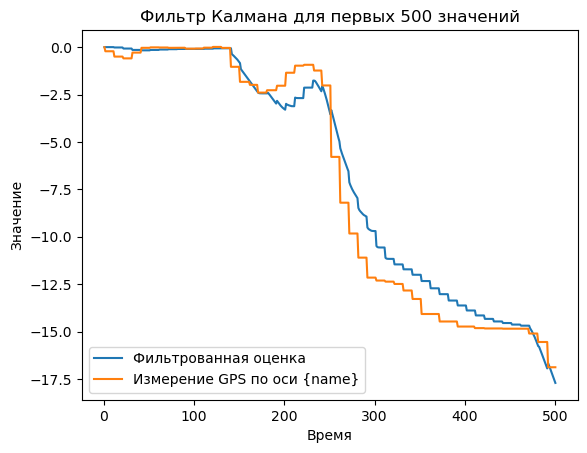

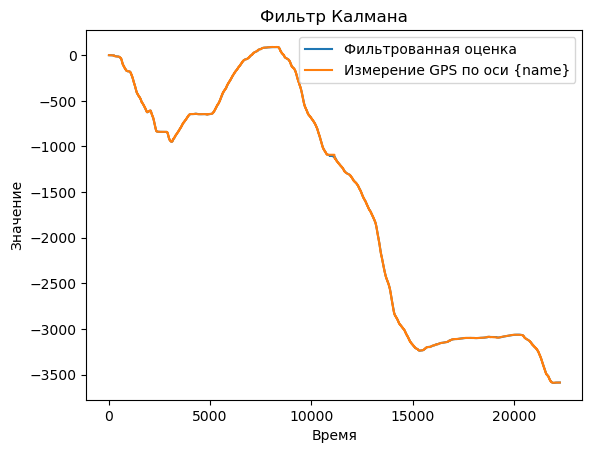

In [54]:

plot_graf(buf_x, Longitude, 'Y')

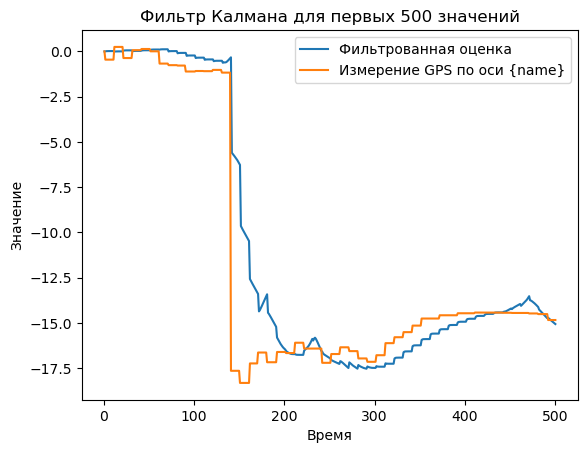

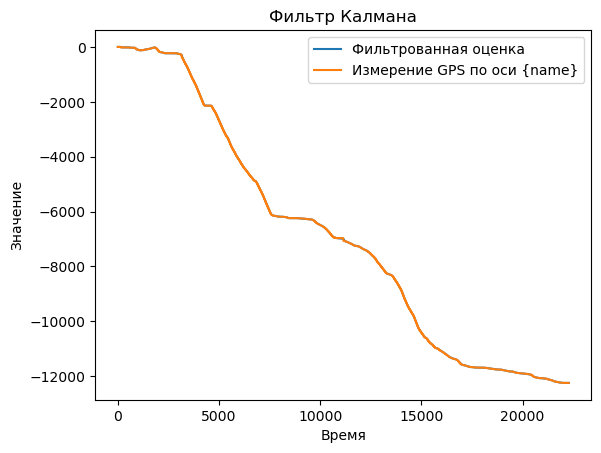

In [56]:
plot_graf(buf_y, Latitude, 'Y')
